# Advanced HPC Program Project

### Kuwahara filter - Fine-art transformation

Prof. Tran Giang Son

Student Vu Trung Dung

1 x RTX 3060
Xeon® E5-2699 v3

### Helpers & Definitions

In [2]:
!nvidia-smi

Mon Nov 11 15:53:40 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.107.02             Driver Version: 550.107.02     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060        On  |   00000000:07:00.0 Off |                  N/A |
| 51%   50C    P8             14W /  170W |       1MiB /  12288MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import pathlib as pl

IMAGE_PATH_BASE = pl.Path('/root/images')

In [4]:
from tqdm.notebook import tqdm

def utils__range(n, desc="", show_progress=True, inside=False):
  if desc: show_progress = True
  if show_progress:
    return tqdm(range(n), desc=desc, leave=inside)
  else:
      return range(n)

def side_by_side(origin, after):
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(origin)
    
    plt.subplot(1, 2, 2)
    plt.title("After Image")
    plt.imshow(after)
    
    plt.show()

## GPU Implementation

### RGB -  HSV convert

In [5]:
from numba import cuda
import numba
import numpy as np
import time

@cuda.jit
def rgb2hsv(src, dst, h, w):
  tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
  tidy = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y

  if tidx >= w or tidy >= h:
    return

  r, g, b = src[tidy, tidx]
  r = np.float32(r) / 255
  g = np.float32(g) / 255
  b = np.float32(b) / 255

  max_val = max(r, max(g, b))
  min_val = min(r, min(g, b))
  delta = max_val - min_val

  v = max_val
  s = 0 if max_val == 0 else np.float32(delta / max_val)
  if delta == 0:
    h = 0
  elif max_val == r:
    h = 60 * ((np.float32(g-b)/delta) % 6)
  elif max_val == g:
    h = 60 * (np.float32(b-r)/delta + 2)
  else:
    h = 60 * (np.float32(r-g)/delta + 4)

  dst[0, tidy, tidx] = h
  dst[1, tidy, tidx] = s
  dst[2, tidy, tidx] = v


def convert_rgb2hsv(img, blockSize=(32, 32)):
  h, w = img.shape[0], img.shape[1]
  gridSize = (
    (w + blockSize[1] - 1) // blockSize[1],
    (h + blockSize[0] - 1) // blockSize[0],
  )

  start_t = time.time()

  devSrc = cuda.to_device(img)
  devDst = cuda.device_array((3, h, w), np.float32)

  rgb2hsv[gridSize, blockSize](devSrc, devDst, h, w)
  hsv = devDst.copy_to_host()

  ct = time.time() - start_t

  return ct, hsv


In [6]:
from numba import cuda
import numba
import numpy as np
import time


@cuda.jit
def hsv2rgb(src_h, src_s, src_v, dst, h, w):
  tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
  tidy = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y

  if tidx >= w or tidy >= h:
    return

  H, S, V = src_h[tidy, tidx], src_s[tidy, tidx], src_v[tidy, tidx]

  d = H/60
  hi = np.uint8(d) % 6
  f = d - hi
  l = V * (1 - S)
  m = V * (1 - f*S)
  n = V * (1 - (1 - f)*S)

  if H < 60:
    r, g, b = V, n, l
  elif H < 120:
    r, g, b = m, V, l
  elif H < 180:
    r, g, b = l, V, n
  elif H < 240:
    r, g, b = l, m, V
  elif H < 300:
    r, g, b = n, l, V
  else:
    r, g, b = V, l, m

  dst[tidy, tidx, 0] = np.uint8(r * 255)
  dst[tidy, tidx, 1] = np.uint8(g * 255)
  dst[tidy, tidx, 2] = np.uint8(b * 255)


def convert_hsv2rgb(hsv, blockSize=(32, 32)):
  h, w = hsv.shape[1], hsv.shape[2]
  gridSize = (
    (w + blockSize[1] - 1) // blockSize[1],
    (h + blockSize[0] - 1) // blockSize[0],
  )

  start_t = time.time()

  devSrc = cuda.to_device(hsv)
  devDst = cuda.device_array((h, w, 3), np.uint8)

  hsv2rgb[gridSize, blockSize](devSrc[0], devSrc[1], devSrc[2], devDst, h, w)
  rgb = devDst.copy_to_host()

  ct = time.time() - start_t

  return ct, rgb

Total time 0.7813622951507568 seconds


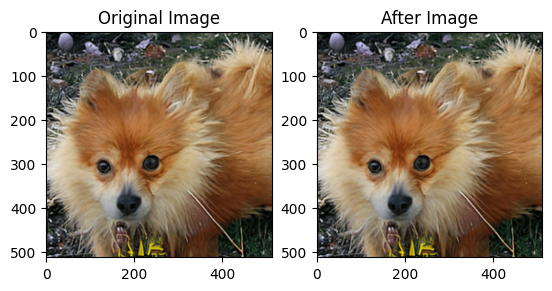

In [7]:
# Test RGB, HSV convert

img_rgb_orig = plt.imread(IMAGE_PATH_BASE / "small_512x512.jpg")

ct = 0
_ct, hsv_soa = convert_rgb2hsv(img_rgb_orig, (32, 32))
ct += _ct
_ct, rgb_aos = convert_hsv2rgb(hsv_soa, (32, 32))
ct += _ct

print(f"Total time {ct} seconds")

side_by_side(img_rgb_orig, rgb_aos)

### Kuwahara filter GPU

In [8]:
from numba import cuda
import numba
import numpy as np
import time

@cuda.jit
def mean_of(array_2d, left_x, top_y, size, img_h, img_w):
    total, n = 0, 0
    for i in range(top_y, top_y + size):
        for j in range(left_x, left_x + size):
            if i < img_h and j < img_w:
                total += array_2d[i, j]
                n += 1
    return np.float32(total) / np.float32(n) if n > 0 else 0
    
@cuda.jit
def variance_of(array_2d, left_x, top_y, size, img_h, img_w):
    mean = mean_of(array_2d, left_x, top_y, size, img_h, img_w)
    
    total_squared_diffs, n = 0, 0
    for i in range(top_y, top_y + size):
        for j in range(left_x, left_x + size):
            if i < img_h and j < img_w:
                total_squared_diffs += array_2d[i, j]
                n += 1
    variance = np.float32(total_squared_diffs) / np.float32(n) if n > 0 else 0
    return variance

@cuda.jit
def mean_rgb_of(d_image, left_x, top_y, size, img_h, img_w):
    r, g, b = 0, 0, 0
    n = np.float32(0)
    for i in range(top_y, top_y + size):
        for j in range(left_x, left_x + size):
            if i < img_h and j < img_w:
                r += d_image[i, j, 0]
                g += d_image[i, j, 1]
                b += d_image[i, j, 2]
                n += 1
    if n > 0:
        r, g, b = r/n, g//n, b//n

    return r, g, b

@cuda.jit
def kuwahara_simple_kernel(d_image, d_v_input, d_output, window_size, img_h, img_w):
    tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    tidy = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y

    if tidx >= img_w or tidy >= img_h:
        return
    
    offset = window_size // 2

    # Find the sub_regions with min variance
    min_variances = np.inf
    best_leftx, best_topy = 0, 0
    for iy in [-offset, 0]:
        for ix in [-offset, 0]:
            left_x = max(0, tidx+ix)
            top_y = max(0, tidy+iy)
            variances = variance_of(d_v_input, left_x, top_y, offset, img_h, img_w)
            if variances < min_variances:
                min_variances = variances
                best_leftx, best_topy = left_x, top_y
    # Calculate the mean (r, g, b) of best variance
    r, g, b = mean_rgb_of(d_image, best_leftx, best_topy, offset, img_h, img_w)

    d_output[tidy, tidx, 0] = r
    d_output[tidy, tidx, 1] = g
    d_output[tidy, tidx, 2] = b

def default_kernel_factory(**kwargs):
    return kuwahara_simple_kernel
    
def kuwahara_filter(image, window_size=5, block_size=(32, 32), kernel_factory=default_kernel_factory):
    # Ensure the window size is odd and at least 3
    if window_size % 2 == 0 or window_size < 3:
        raise ValueError("Window size should be an odd number >= 3.")

    img_h, img_w = img.shape[:2]
    gridSize = (
        (img_w + block_size[1] - 1) // block_size[1],
        (img_h + block_size[0] - 1) // block_size[0],
    )

    kernel = kernel_factory(block_size=block_size)

    d_input = cuda.to_device(image)
    d_output = cuda.device_array((img_h, img_w, 3), np.uint8)
    d_hsv_output = cuda.device_array((img_h, img_w, 3), np.uint8)

    # run multiple time and get the last one as the runtime
    for i in range(5):
        start_t = time.time()
        rgb2hsv[gridSize, block_size](d_input, d_hsv_output, img_h, img_w)
        d_v_input = d_hsv_output[2]
        kernel[gridSize, block_size](d_input, d_v_input, d_output, window_size, img_h, img_w)
        cuda.synchronize()
        dst = d_output.copy_to_host()
  
    ct = time.time() - start_t

    return ct, dst
    

It took 0.0020351409912109375s to finish


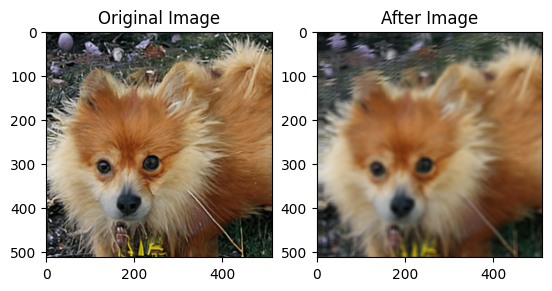

In [9]:
# Test RGB, HSV convert
img = plt.imread(IMAGE_PATH_BASE / "small_512x512.jpg")
ct, after = kuwahara_filter(img, 21)
print(f"It took {ct}s to finish")
side_by_side(img, after)

### Performance improve

- With Share memory

In [10]:
# TODO

## CPU Implementation

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from matplotlib.colors import rgb_to_hsv

def kuwahara_filter_cpu(image, window_size=5, show_progress=True):
    # Ensure the window size is odd and at least 3
    if window_size % 2 == 0 or window_size < 3:
        raise ValueError("Window size should be an odd number >= 3.")
    
    offset = window_size // 2
    h, w = image.shape[:2]
    
    # Pad the image to handle borders
    padded_image = np.pad(image, offset, mode='reflect')[:, :, offset:offset+3]
    filtered_image = np.zeros_like(image)
    
    image_hsv = rgb_to_hsv(padded_image)
    v_channel = image_hsv[:, :, 2]
    
    for i in utils__range(h, "Rows"):
        for j in utils__range(w, "Columns"):
            # Find the best region
            region_v = padded_image[i:i + window_size, j:j + window_size]
            sub_regions_v = [
                region_v[0:offset+1, 0:offset+1],   # Top-left
                region_v[0:offset+1, offset:],      # Top-right
                region_v[offset:, 0:offset+1],      # Bottom-left
                region_v[offset:, offset:]          # Bottom-right
            ]
            variances = [sub.var() for sub in sub_regions_v]
            min_variance_index = np.argmin(variances)
            
            def get_mean_region(index):
                region = padded_image[i:i + window_size, j:j + window_size]
        
                sub_regions = [
                    lambda: region[0:offset+1, 0:offset+1],   # Top-left
                    lambda: region[0:offset+1, offset:],      # Top-right
                    lambda: region[offset:, 0:offset+1],      # Bottom-left
                    lambda: region[offset:, offset:]          # Bottom-right
                ]
                mean = sub_regions[index]().mean(axis=(0,1))
                return mean
            
            filtered_image[i, j] = get_mean_region(min_variance_index)
    
    return filtered_image


In [12]:
image = plt.imread(IMAGE_PATH_BASE / "small_256x256_grayscale.jpg")
filtered_image = kuwahara_filter_cpu(image, window_size=5)

Rows:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

In [13]:
from matplotlib.colors import rgb_to_hsv

image_rgb = plt.imread(IMAGE_PATH_BASE / "small_256x256.jpg")
image_hsv = rgb_to_hsv(image_rgb)
print(image_hsv.shape)
v_channel = image_hsv[:, :, 2]
print(v_channel)

(512, 512, 3)
[[  5.   4.   4. ...  45.  53.  64.]
 [  7.   7.   7. ...  42.  63.  71.]
 [  2.   3.   5. ...  61.  87.  83.]
 ...
 [ 29.  18.  37. ...  53.  71.  66.]
 [ 70.  69. 192. ...  54.  64.  68.]
 [ 70.  80. 196. ...  46.  72.  70.]]


## Experiment

#### Experiment with multiple block_size options

This section is to find the best block_size settings

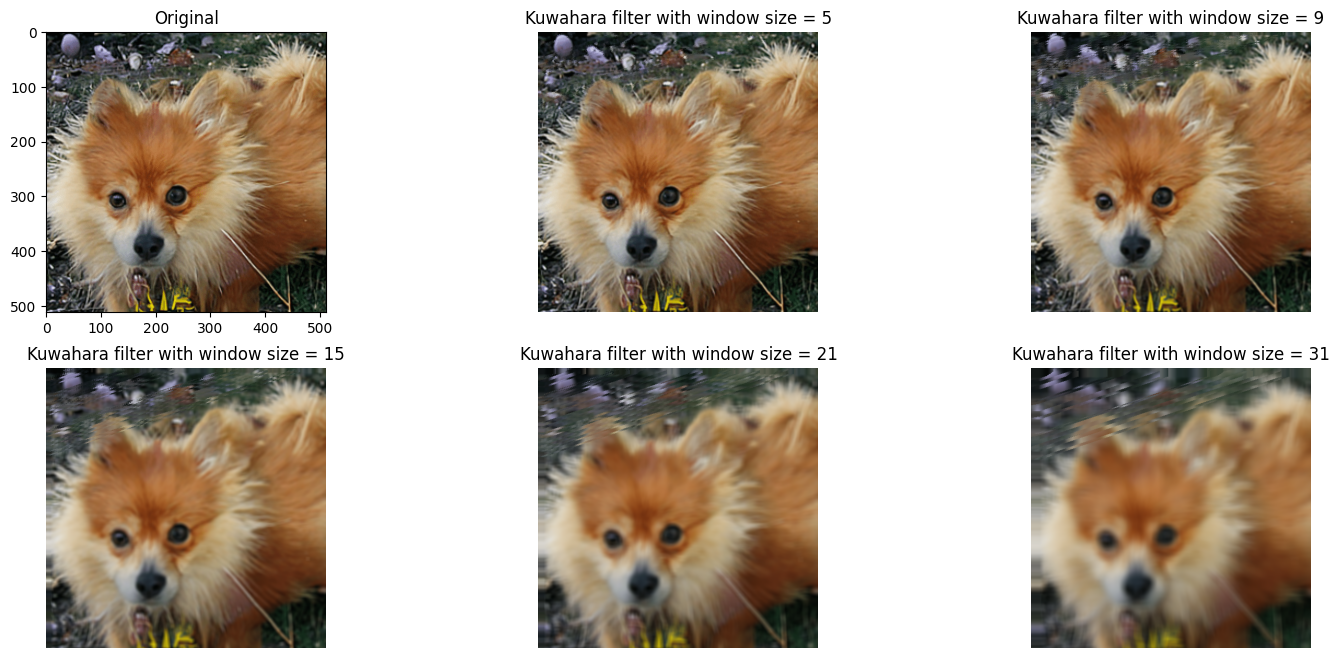

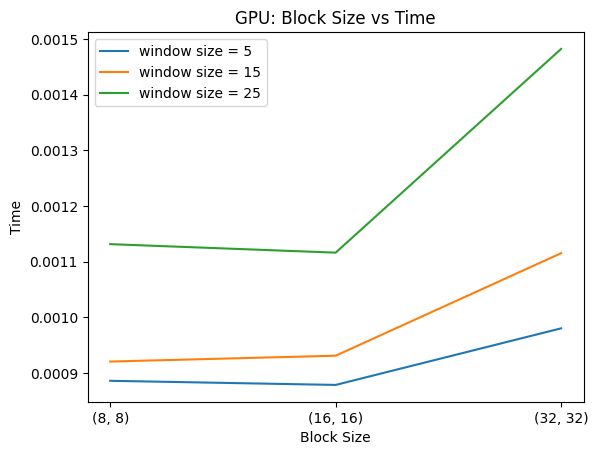

In [14]:
import matplotlib.pyplot as plt

# Process in 2D grid
block_sizes = [
   (8, 8), (16, 16), (32, 32),
]
window_sizes = [
    5, 9, 15, 21, 31
]

times = []
images = []

img = plt.imread(IMAGE_PATH_BASE / "small_256x256.jpg")

for ws in window_sizes:
    times.append([])
    for i, block_size in enumerate(block_sizes):
        ct, after = kuwahara_filter(img, ws, block_size=block_size)
        times[-1].append(ct)
    images.append(after)

# Show all images first
fig, ax = plt.subplots(2, 3, figsize=(18, 8))
ax = ax.flatten()

ax[0].imshow(img)
ax[0].set_title("Original")

for i, img in enumerate(images):
    ax[i+1].imshow(img)
    ax[i+1].set_title(f"Kuwahara filter with window size = {window_sizes[i]}")
    ax[i+1].set_axis_off()
    
# Plot a graph of block size vs time

fig, ax = plt.subplots()

x_labels = [str(dim) for dim in block_sizes]
ax.plot(x_labels, times[0], label="window size = 5")
ax.plot(x_labels, times[1], label="window size = 15")
ax.plot(x_labels, times[2], label="window size = 25")
ax.set_title('GPU: Block Size vs Time')
ax.set_xlabel('Block Size')
ax.set_ylabel('Time')
ax.legend()

plt.show()



#### Speedup CPU -> GPU

This section is to compare the CPU and GPU processing time.

In [ ]:
import matplotlib.pyplot as plt

# Process in 2D grid
block_sizes = (16, 16)
window_sizes = 9

print("here")

origins = [
    plt.imread(IMAGE_PATH_BASE / "small_256x256.jpg"),
    plt.imread(IMAGE_PATH_BASE / "small_image_01.jpg"),
    plt.imread(IMAGE_PATH_BASE / "anh.jpg"),
]

print("here")

images = []
cpu_times = []
gpu_times = []

for img in origins:
    print("Process image ...")
    t = time.time()
    kuwahara_filter_cpu(img, window_sizes, show_progress=False)
    cpu_times.append(time.time() - t)
    
    ct, after = kuwahara_filter(img, ws, block_size=block_size)
    times[-1].append(ct)
    gpu_times.append(ct)
    images.append(after)

# Show all images first
fig, ax = plt.subplots(2, 3, figsize=(18, 8))
ax = ax.flatten()

ax[0].imshow(img)
ax[0].set_title("Original")

for i, img in enumerate(images):
    ax[i+1].imshow(img)
    ax[i+1].set_title(f"Kuwahara filter, image dimension ({img.shape[0]}x{img.shape[1]})")
    ax[i+1].set_axis_off()

speedup = [np.float32(tc)/tg for tc, tg in zip(cpu_times, gpu_times)]
# Plot a graph of block size vs time

fig, ax = plt.subplots()

x_labels = [str(img.shape[0]*img.shape[1]) for img in origins]
ax.plot(x_labels, times[0])
ax.set_title('GPU vs CPU speed up')
ax.set_xlabel('Image size in pixel')
ax.set_ylabel('Speedup')

plt.show()



here
here
Process image ...


Rows:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]

Columns:   0%|          | 0/512 [00:00<?, ?it/s]